In [2]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
# Render the figure in a notebook:
%matplotlib inline  

from scipy import stats

from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree

from sklearn import metrics

import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F

from torchmetrics.classification import Accuracy
from torchmetrics.classification import Recall
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from torchmetrics import R2Score
from torchmetrics import MeanAbsoluteError

from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
x_train = pd.read_csv('../no_nontoxic_nans_X_train.csv',index_col=0)
y_train = pd.read_csv('../no_nontoxic_nans_y_train.csv',index_col=0)

x_val = pd.read_csv('../no_nontoxic_nans_x_val.csv',index_col=0)
y_val = pd.read_csv('../no_nontoxic_nans_y_val.csv',index_col=0)

x_test = pd.read_csv('../no_nontoxic_nans_x_test.csv',index_col=0)
y_test = pd.read_csv('../no_nontoxic_nans_y_test.csv',index_col=0)

In [5]:
#Remove all nan values from the df
mask = x_train.notna().all(axis=1)

x_train_clean = x_train[mask]
y_train_clean = y_train[mask]

mask2 = x_test.notna().all(axis=1)

x_test_clean = x_test[mask2]
y_test_clean = y_test[mask2]

mask3 = x_val.notna().all(axis=1)

x_val_clean = x_val[mask3]
y_val_clean = y_val[mask3]

In [6]:
### You have been using DataFrames because these are easy to deal with but here we need the data as an array

x_train_array = x_train_clean.to_numpy()
x_train_tensor = torch.Tensor(x_train_array)

### Now some properties will be printed so you can see how this is similar to a NumPy array

print(f'X_train_tensor = {x_train_tensor}')

print(f'Size of X_train_tensor = {x_train_tensor.size()}') 

print(f'Data type of X_train_tensor = {x_train_tensor.dtype}')

X_train_tensor = tensor([[ 0.7823,  0.7823, -0.4119,  ..., -0.0907, -0.2697, -0.1562],
        [ 0.5145,  0.5145, -0.7155,  ..., -0.0907, -0.2697, -0.1562],
        [-1.5689, -1.5689,  0.6186,  ..., -0.0907, -0.2697, -0.1562],
        ...,
        [ 0.2563,  0.2563, -0.5645,  ..., -0.0907, -0.2697, -0.1562],
        [ 0.2330,  0.2330, -0.1187,  ..., -0.0907, -0.2697, -0.1562],
        [ 0.7342,  0.7342, -0.7105,  ..., -0.0907, -0.2697, -0.1562]])
Size of X_train_tensor = torch.Size([3607, 217])
Data type of X_train_tensor = torch.float32


In [7]:
x_val_array = x_val_clean.to_numpy()
x_val_tensor = torch.Tensor(x_val_array)

y_train_array = y_train_clean['toxic'].to_numpy()
y_train_tensor = torch.Tensor(y_train_array)

y_val_array = y_val_clean['toxic'].to_numpy()
y_val_tensor = torch.Tensor(y_val_array)

x_test_array = x_test_clean.to_numpy()
x_test_tensor = torch.Tensor(x_test_array)

y_test_array = y_test_clean.to_numpy()
y_test_tensor = torch.Tensor(y_test_array)

In [8]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

In [9]:
class DNN_3_layer(nn.Module):
    def __init__(self):
        super(DNN_3_layer, self).__init__()
        self.fc1 = nn.Linear(217, 108)        
        self.fc2 = nn.Linear(108, 54)
        self.fc3 = nn.Linear(54, 27)
        self.fc4 = nn.Linear(27,2)
           
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) # For the final layer we use raw logits for the cross entropy loss
        return x

In [ ]:
#test the SGD model with optimised params
def test_SGD_metrics(network, learning_rate, best_epochs, trainloader, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor, x_test_tensor, y_test_tensor):
    epoch_list = []
    avg_train_loss_list =[]
    
    network.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

    num_epochs = best_epochs  
    torch.manual_seed(0)

    for epoch in range(1,num_epochs+1):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data 
            optimizer.zero_grad() 
            outputs = network(inputs)
            loss = criterion(outputs, labels.long()) 
            loss.backward() 
            optimizer.step() 
            running_loss += loss.item() 
                
        avg_train_loss = running_loss / len(trainloader) 
        avg_train_loss_list.append(avg_train_loss)
        epoch_list.append(epoch)

    network.eval()
    with torch.no_grad():  # stops gradient tracking
        y_train_logits = network(x_train_tensor).detach() 
        y_train_pred = torch.argmax(y_train_logits, dim=1) 

        y_val_logits = network(x_val_tensor).detach() 
        global y_val_pred #want to use y_val_pred later!
        y_val_pred = torch.argmax(y_val_logits, dim=1) 
        
        y_test_logits = network(x_test_tensor).detach() 
        y_test_pred = torch.argmax(y_test_logits, dim=1) 

    # ConfusionMatrixDisplay.from_predictions(y_train_tensor, y_train_pred)
    # ConfusionMatrixDisplay.from_predictions(y_val_tensor, y_val_pred)
    # ConfusionMatrixDisplay.from_predictions(y_test_tensor, y_test_pred)

In [19]:
def return_classifications(y_true, y_predicted): #use y_val and y_predicted
    ## Correct is 0 
    # FP is -1 
    # FN is 1
    # from https://stackoverflow.com/questions/61893001/get-list-of-true-positives-false-positives-false-negatives-and-true-negatives
    diff = y_true-y_predicted
    return diff
network = DNN_3_layer()
test_SGD_metrics(network, 0.14, 100, trainloader, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor, x_test_tensor, y_test_tensor)

In [29]:
df_diff = pd.DataFrame(return_classifications(np.array(y_val_array),np.array(y_val_pred)))

C:\Users\dx21006\AppData\Local\Temp\ipykernel_6084\562089718.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  df_diff = pd.DataFrame(return_classifications(np.array(y_val_array),np.array(y_val_pred)))


In [30]:
x_val_classifications = x_val.reset_index(drop=True)
df_diff.reset_index(drop=True)
x_val_classifications = x_val_classifications.join(df_diff[0])
x_val_classifications.rename(columns={0 :'classification'}, inplace=True)
#rename the 0 column to classification

In [32]:
#need to extract the smiles from the original data, so we can work out what is wrong.

desc_and_tox = pd.read_csv('../no_nontoxic_nans_desc_and_toxicity.csv',index_col=0) #need to reread the dataframe with the smiles strings etc.
x = 0 #where to put in x_val_classifications (indexing starts at 0)
for i in x_val.index:
    x_val_classifications.loc[x, 'smiles'] = desc_and_tox.loc[i, 'smiles'] #for the corresponding compounds in x_val, add the smiles into x_val
    x+=1
x_val_classifications

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,classification,smiles
0,-0.356310,-0.356310,-0.668658,0.481564,0.840437,-0.549179,-0.555916,-0.518916,-0.560850,-0.716999,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,0.0,OCc1ccc(Cl)cc1Cl
1,1.042599,1.042599,-0.371607,-0.101258,0.864879,-0.456316,0.582595,0.627387,0.580999,0.511459,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,0.0,COc1ccc2c(C(=O)c3ccc(Cl)cc3)c(C)n(CC(=O)O)c2c1
2,-1.404615,-1.404615,-0.008815,0.714963,1.718226,0.224084,0.208176,0.214603,0.209411,0.279048,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,-1.0,c1cnc(N2CCN(Cc3ccc4c(c3)OCO4)CC2)nc1
3,-2.407357,-2.407357,1.427983,1.099017,0.513815,-0.386624,0.139272,0.120821,0.140209,0.212645,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,-1.0,CN(C/C=C/c1ccccc1)Cc1cccc2ccccc12
4,0.685925,0.685925,-0.729110,0.410973,1.145224,-0.552472,-0.422447,-0.403677,-0.421578,-0.384983,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,0.0,O=C(c1ccccc1)c1ccccc1O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,-1.220501,-1.220501,1.046073,0.996933,0.914967,0.006197,0.381362,0.385733,0.379598,0.345451,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,NaN,Clc1ccc(Cn2c(CN3CCCC3)nc3ccccc32)cc1
788,0.426925,0.426925,-0.429024,0.023641,-0.645198,-0.581639,-0.313038,-0.259935,-0.314828,-0.384983,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,NaN,COC(=O)c1cc(Cl)ccc1[N+](=O)[O-]
789,-1.490748,-1.490748,1.294373,-0.875402,0.146147,-0.341719,-0.636239,-0.672262,-0.635835,-0.584192,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,NaN,CCC[Si](OC)(OC)OC
790,0.890160,0.890160,-0.761232,-1.593262,1.442414,0.304538,0.561678,0.537386,0.562617,0.611064,...,8.845356,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,NaN,CCN1CCCC1CNC(=O)c1cc(S(=O)(=O)CC)ccc1OC


# here are our false negatives!

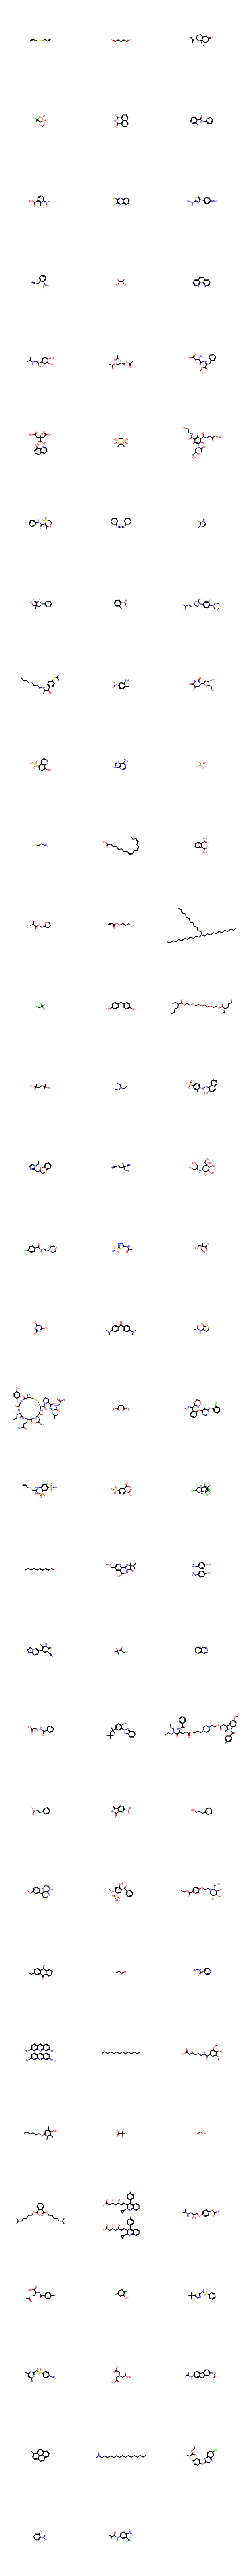

In [43]:
#we are concerned about false negatives, i.e. classification = 1. search for values where 'classification' value is 1. Change this value to look for other types of classifications.
falsenegsmiles = x_val_classifications['smiles'][x_val_classifications['classification']==1]
import rdkit
falsenegsmiles_list = [rdkit.Chem.MolFromSmiles(x) for x in falsenegsmiles]
rdkit.Chem.Draw.MolsToGridImage(falsenegsmiles_list, maxMols=len(falsenegsmiles_list))

In [40]:
# for smiles in falsenegsmiles:
#     print(smiles,'\n')